## IMDb Movie Reviews

In [2]:
## Step 1 — Import Libraries
import os
import pandas as pd
import re
import string
from bs4 import BeautifulSoup
import nltk

# Download resources for stopwords + lemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bbuser\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\bbuser\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\bbuser\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [5]:
import os
import pandas as pd
import time

def load_imdb_data_safe(base_path, max_per_class=None, verbose=True):
    """
    Load text files from base_path/pos and base_path/neg into a DataFrame.
    - max_per_class: if set, read at most this many files per class (useful for quick tests).
    - verbose: prints progress.
    """
    if not os.path.isdir(base_path):
        raise FileNotFoundError(f"Base path does not exist: {base_path}")

    pos_dir = os.path.join(base_path, "pos")
    neg_dir = os.path.join(base_path, "neg")
    if not os.path.isdir(pos_dir) or not os.path.isdir(neg_dir):
        raise FileNotFoundError(f"'pos' or 'neg' folder missing in {base_path}. Found: {os.listdir(base_path)}")

    pos_files = sorted(os.listdir(pos_dir))
    neg_files = sorted(os.listdir(neg_dir))

    if verbose:
        print(f"Found {len(pos_files)} pos files and {len(neg_files)} neg files.")
        print("First few pos files:", pos_files[:5])

    texts = []
    labels = []

    def _read_list(file_list, directory, label):
        read_count = 0
        for i, fname in enumerate(file_list):
            if max_per_class is not None and read_count >= max_per_class:
                break
            full = os.path.join(directory, fname)
            try:
                with open(full, 'r', encoding='utf-8') as f:
                    texts.append(f.read())
                    labels.append(label)
            except UnicodeDecodeError:
                # fallback encoding
                try:
                    with open(full, 'r', encoding='latin-1') as f:
                        texts.append(f.read())
                        labels.append(label)
                except Exception as e:
                    if verbose:
                        print(f"Skipping file due to read error: {full} -> {e}")
            except Exception as e:
                if verbose:
                    print(f"Skipping file due to error: {full} -> {e}")

            read_count += 1
            # print progress
            if verbose and read_count % 500 == 0:
                print(f"Read {read_count} files from {directory}...")

    start = time.time()
    _read_list(pos_files, pos_dir, 1)
    _read_list(neg_files, neg_dir, 0)
    elapsed = time.time() - start

    if verbose:
        print(f"Finished reading. Total reviews read: {len(texts)}. Time elapsed: {elapsed:.1f}s")

    return pd.DataFrame({"review": texts, "label": labels})

# Quick test (reads only 200 files per class for speed)
train_path = r"C:/Users/bbuser/Desktop/python_sprint9/aclImdb/train"   # change to the correct absolute path if needed
train_df = load_imdb_data_safe(train_path, max_per_class=200, verbose=True)
print(train_df.shape)
train_df.head()


Found 12500 pos files and 12500 neg files.
First few pos files: ['0_9.txt', '10000_8.txt', '10001_10.txt', '10002_7.txt', '10003_8.txt']
Finished reading. Total reviews read: 400. Time elapsed: 0.2s
(400, 2)


,review,label
0,Bromwell High is a cartoon comedy. It ran at t...,1
1,Homelessness (or Houselessness as George Carli...,1
2,Brilliant over-acting by Lesley Ann Warren. Be...,1
3,This is easily the most underrated film inn th...,1
4,This is not the typical Mel Brooks film. It wa...,1


In [6]:
## Step 3: Cleaning Pipeline
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean_review(text):
    """
    Clean and preprocess a movie review.
    """
    # 1. Lowercase
    text = text.lower()

    # 2. Remove HTML tags
    text = BeautifulSoup(text, "html.parser").get_text()

    # 3. Remove URLs & emails
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    text = re.sub(r"\S+@\S+", "", text)

    # 4. Remove punctuation, numbers, and emojis
    text = re.sub(r"[^a-z\s]", "", text)

    # 5. Tokenize
    tokens = text.split()

    # 6. Remove stopwords + lemmatize
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words and len(w) > 2]

    # 7. Join back
    return " ".join(tokens)

In [7]:
# Apply cleaning
train_df["cleaned_review"] = train_df["review"].apply(clean_review)

# Check results
print(train_df[["review", "cleaned_review"]].head(5))


                                              review  \
0  Bromwell High is a cartoon comedy. It ran at t...   
1  Homelessness (or Houselessness as George Carli...   
2  Brilliant over-acting by Lesley Ann Warren. Be...   
3  This is easily the most underrated film inn th...   
4  This is not the typical Mel Brooks film. It wa...   

                                      cleaned_review  
0  bromwell high cartoon comedy ran time program ...  
1  homelessness houselessness george carlin state...  
2  brilliant overacting lesley ann warren best dr...  
3  easily underrated film inn brook cannon sure f...  
4  typical mel brook film much less slapstick mov...  


In [8]:
## step 5 : Deliverable:  Before/After Examples
examples = train_df.sample(5, random_state=42)
for i, row in examples.iterrows():
    print("RAW:", row["review"][:200])  # print first 200 chars
    print("CLEANED:", row["cleaned_review"])
    print("-"*80)


RAW: The film is bad. There is no other way to say it. The story is weak and outdated, especially for this country. I don't think most people know what a "walker" is or will really care. I felt as if I was
CLEANED: film bad way say story weak outdated especially country dont think people know walker really care felt watching movie subject believable year even set think rang true everyone else watched applause low quick end didnt stay eitheri dont think schrader really thought film ahead time many scene seemed cut short never finished didnt know finish jumped one scene next try figure guess going really didnt get woodys carter private life boyfriend either artistic male bondage torture picture iraq prison thinking think poor attempt trying create dark private subculture life woodys character car didnt work didnt even seem make sense reallythe good thing film woody harrelson played character car flawlessly really get great sense walker may like say twenty year ago great likely never get 

In [9]:
## Step 6 : Optional

from sklearn.feature_extraction.text import TfidfVectorizer

# Split features (X) and labels (y)
X = train_df["cleaned_review"]
y = train_df["label"]

# Convert text to TF-IDF features
vectorizer = TfidfVectorizer(max_features=5000)  # limit to top 5000 words
X_tfidf = vectorizer.fit_transform(X)

print("Shape of TF-IDF matrix:", X_tfidf.shape)


Shape of TF-IDF matrix: (400, 5000)


In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", X_train.shape, "Test size:", X_test.shape)


Train size: (320, 5000) Test size: (80, 5000)


In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Train Logistic Regression
log_reg = LogisticRegression(max_iter=1000, n_jobs=-1)
log_reg.fit(X_train, y_train)

# Predictions
y_pred_log = log_reg.predict(X_test)

# Evaluation
print("🔹 Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))

🔹 Logistic Regression Accuracy: 0.9125
              precision    recall  f1-score   support

           0       0.95      0.88      0.91        40
           1       0.88      0.95      0.92        40

    accuracy                           0.91        80
   macro avg       0.91      0.91      0.91        80
weighted avg       0.91      0.91      0.91        80



In [12]:
from sklearn.naive_bayes import MultinomialNB

# Train Naive Bayes
nb = MultinomialNB()
nb.fit(X_train, y_train)

# Predictions
y_pred_nb = nb.predict(X_test)

# Evaluation
print("🔹 Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))


🔹 Naive Bayes Accuracy: 0.8875
              precision    recall  f1-score   support

           0       0.90      0.88      0.89        40
           1       0.88      0.90      0.89        40

    accuracy                           0.89        80
   macro avg       0.89      0.89      0.89        80
weighted avg       0.89      0.89      0.89        80



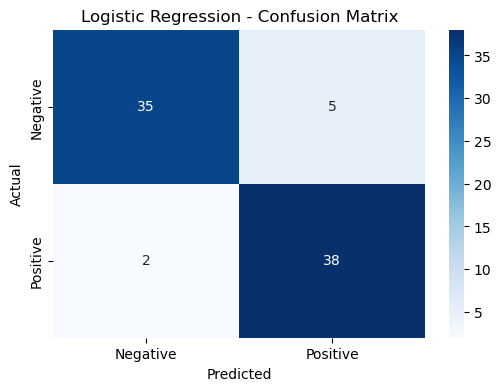

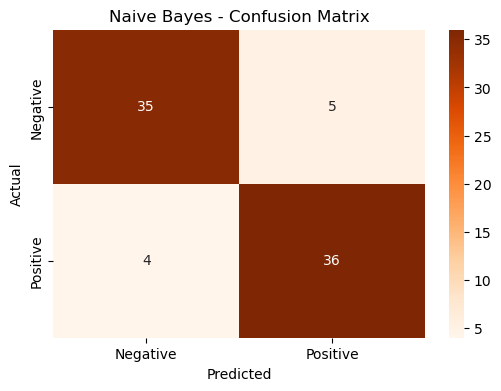

In [13]:
## Step 7 : Confusion Matrices (Optional Visualization)
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion matrix for Logistic Regression
cm_log = confusion_matrix(y_test, y_pred_log)
plt.figure(figsize=(6,4))
sns.heatmap(cm_log, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative","Positive"], yticklabels=["Negative","Positive"])
plt.title("Logistic Regression - Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

# Confusion matrix for Naive Bayes
cm_nb = confusion_matrix(y_test, y_pred_nb)
plt.figure(figsize=(6,4))
sns.heatmap(cm_nb, annot=True, fmt="d", cmap="Oranges", xticklabels=["Negative","Positive"], yticklabels=["Negative","Positive"])
plt.title("Naive Bayes - Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()


## Task Is Done 